## Model Introduction 

### Python Study

In [1]:
# pip install pymc3;

In [2]:
# pip install seaborn

In [3]:
%pylab inline 
# magic fucntion in ipython. It loads major numerical and plotting libraries

import pandas as pd

import pymc3 as pm
# probabilistic programming language

# import class for constructing random walks
from pymc3.distributions.timeseries import GaussianRandomWalk
import theano.tensor as tt

#import some special methods
from scipy.special import logit,expit
import scipy.stats as stats

# set some plotting parameters to create ggplot-style plots
import seaborn as sns
import matplotlib as mpl
sns.set_context(context='talk',font_scale=1.5)
plt.style.use('ggplot')
mpl.rcParams['axes.labelsize'] = 24

#interactive plotting tools
from ipywidgets import interactive

Populating the interactive namespace from numpy and matplotlib


In [4]:
matplotlib.rcParams['figure.figsize'] = [15,8]

In [5]:
N, p = 10000, 0.01
x = np.random.binomial(N,p,size=1000)

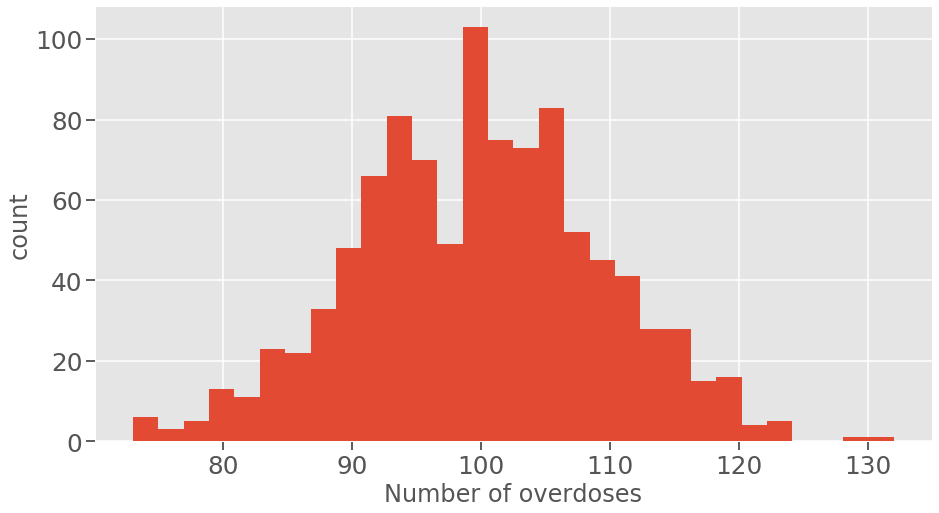

In [6]:
plt.figure(); # ; on plt suppress output
plt.hist(x, bins=30);
plt.xlabel("Number of overdoses");
plt.ylabel("count");

**Important: Shift + tap shows me info about method.**

In [7]:
n_months =12
n_samples = 1000
N,p = 10000,0.01
x = np.random.binomial(N,p, size = (n_samples,n_months))

print('Data generated is a {} by {} array'.format(*x.shape))

Data generated is a 1000 by 12 array


In [8]:
x.shape[1]

12

In [9]:
def plot_data_timeseries(ys, xs=None, xlabel="Month", ylabel="Overdoses", new_plot=True, color="#E14A33", label=None):
    
    '''
    brief intro: plot 95 and IQR
    parameters:
    -----
    ys: sample size by time numpy array 
    xs: x axis as time
    xlabel: string
    ylabel: string
    new_plot: boolean
        plotting to a new figure or not
    color: str
    label: str
    return
    -----
    
    
    '''
    if xs is None:
        xs = np.arange(1,ys.shape[1]+1)
    
    if new_plot: plt.figure;
        # if we wanna make a new plot, then by using plt.figure function,
        # we create a new plot figure
        
    lc, liqr, m, uiqr, uc = np.percentile(ys, [2.5,25,50,75,97.5], axis=0);
    # now it's time to use the (already) existing plot figure
    plt.fill_between(xs, lc, uc,alpha=0.2 ,color=color);
    plt.fill_between(xs, liqr, uiqr, color=color, alpha=0.2);
    plt.plot(xs,m, color= color, label = label);
    plt.xlabel(xlabel);plt.ylabel(ylabel);
    
    

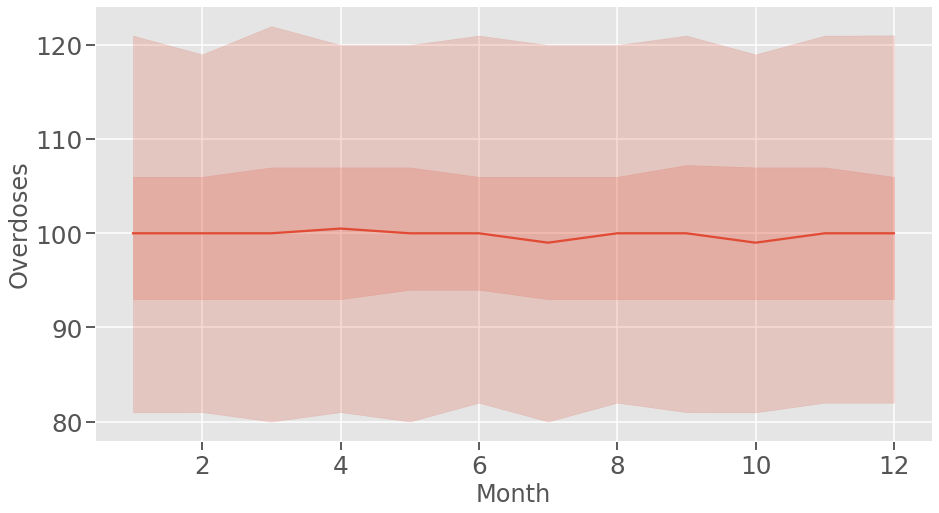

In [10]:
plot_data_timeseries(x)

Broadcasting rule is how numpy treat different arrays in dimensions.

In [11]:
# Note: array is a function to yield a ndarray conviniently, and .flatten() is a method to
# flat the dimension.

np.array([[1,2,3],[1,2,3]]).flatten()

array([1, 2, 3, 1, 2, 3])

In [12]:
# # Note: broadcasting rule examples
# x = np.arange(4)
# print(x)
# print(shape(x))
# xx=x.reshape(4,1)
# print(xx)
# print(shape(xx))
# y = np.ones(5)
# print(y)
# z = np.ones((3,4))
# print(z)

# print(xx+y)
# print(x[:,np.newaxis]+y)
# print(x+z)

# # outer product
# a = np.array([5,6,7,8])
# b = np.array([1,2,3])

# # 4 X 1
# #     3
# # 4 X 3
# print(shape(a))
# print(shape(b))
# print(shape(a.flatten())) #flatten makes (x, )
# print(shape(a[:, np.newaxis].flatten()))
# print(type(a))
# print(a[:, np.newaxis] + b) # This is outer product, where the summatiion
# # occurs elementwise from two vectors.

In [13]:
# Let's make a overdose_generation function.

# instruction: numpy docstring guide.

def overdose_generation():
    '''
    give uncertainty to parameters of the number of overdoses
    
    parameter
    -----
    
    return
    ----
    
    
    '''
    n_samples = 1000
    n_months = 12
    # N follows normal(10000,1000), (1000, 1 )
    N = np.random.normal(loc = 10000, scale = np.sqrt(1000), 
                         size=(n_samples,1)).astype(int)
    # p follows beta (1, 99) (1000, 1 )
    p_alpha, p_beta = 1, 99
    p = np.random.beta(a=1, b=99, size = (n_samples,1))
    # apply N and p to Bin(N,p).  (10000, 12). use Broadcasting rule
    # For each Bin(N,p), repeat 1000 times for one column (month)
    x = np.random.binomial(N, p, size = (n_samples,n_months))
    # (1000,12) ndarray is our result.
    return {'N' : N.flatten(), 'p' : p.flatten(), 'x' : x}
    # Dict: N, p, x for keys, flatten N, p, values.
    

In [14]:
# Note that we can assign variables in a line 
a,b,c,d = 1,2,3,4
print(a,b,c,d)

1 2 3 4


In [15]:
N = np.random.normal(loc = 10000, scale = np.sqrt(1000), 
                         size=(1000,1))
shape(N.astype(int))
print
(type(N.astype(int)[0,0]),
type(N[0,0]))

(numpy.int64, numpy.float64)

Note that we get 
TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'
This is why we change our N to N.astype(int). Match the type of parameter of a function.

In [16]:
data = overdose_generation()
data['N'];

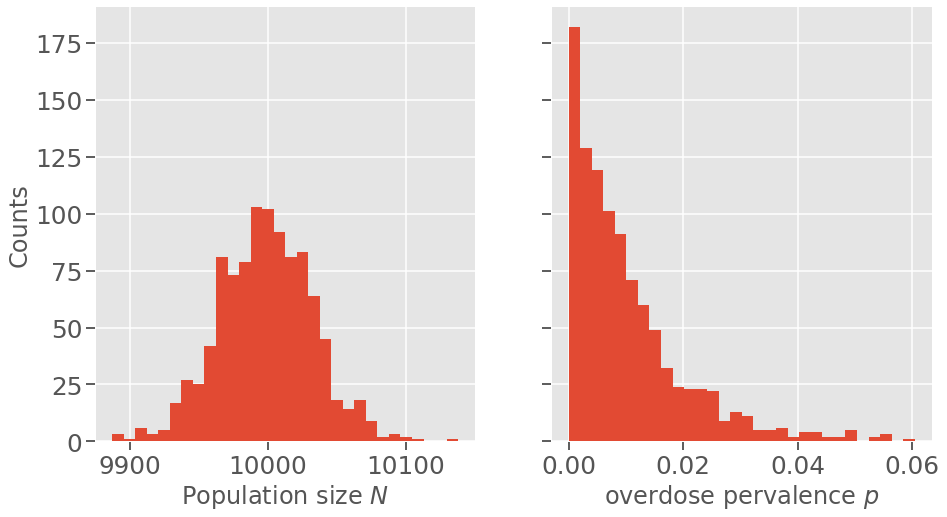

In [17]:
f, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.hist(data['N'],bins=30);
ax1.set_ylabel('Counts');
ax1.set_xlabel('Population size $N$');

ax2.hist(data['p'],bins=30);
ax2.set_xlabel('overdose pervalence $p$');

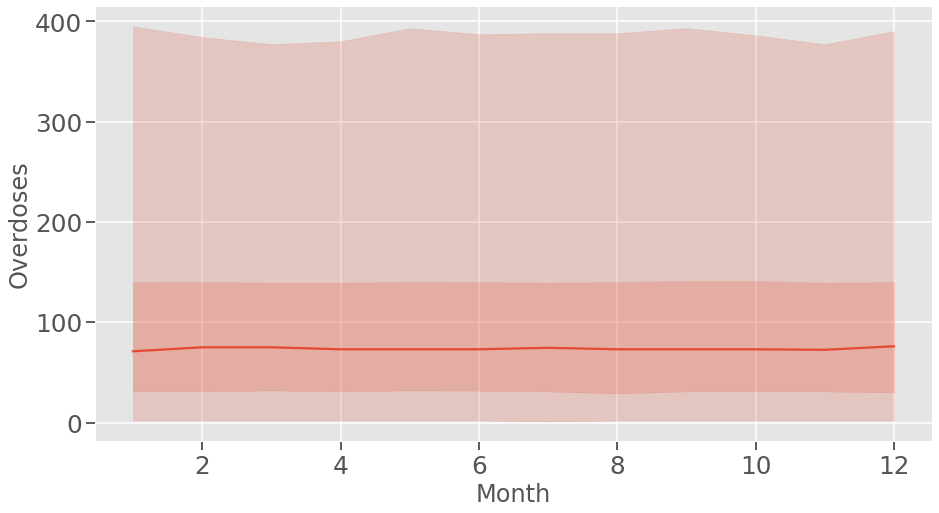

In [18]:
plot_data_timeseries(data['x'])

# Why this happening? 

Maybe it's because the screen is splitted by half.

a random walk with drift, $W_t$.

$$W_t \sim N(w_{t-1} + \mu_w,\sigma_w^2)$$

or alternatively,
$$W_t \sim W_{t-1} + N(\mu_w,\sigma_w^2)$$



[[1 2 3]
 [4 5 6]]


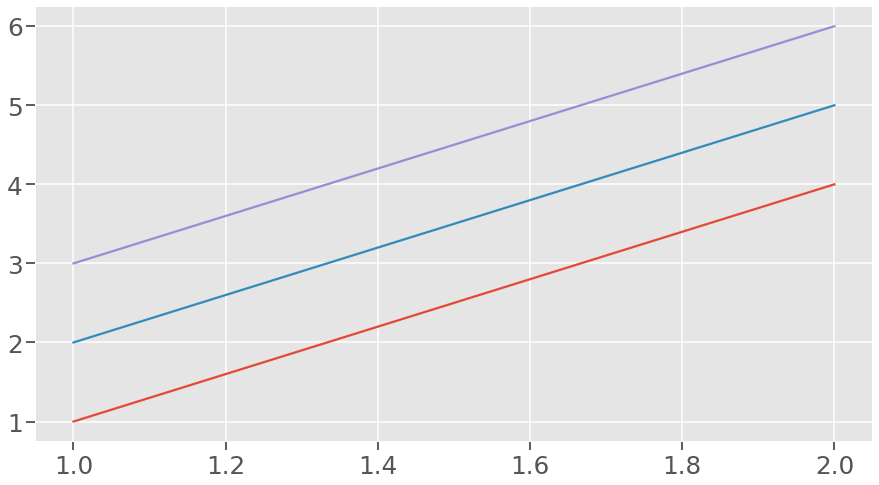

In [19]:
# warming up
x = np.array([[1,2,3],[4,5,6]])
print(x)
# x.cumsum(axis=1)
x.cumsum(axis=0)
y = x.swapaxes(0,1)

np.arange(1,13) # do not take the last one
np.arange(1,13).shape

plt.plot(np.arange(1,3), x)

# plt.plot(np.arange(1,3), y): error of first dimension 

#  It seems for x axis, first dimension of x is taken as well as 
# y's first dimension, then for y's second dimension,
# different colours is used for them.

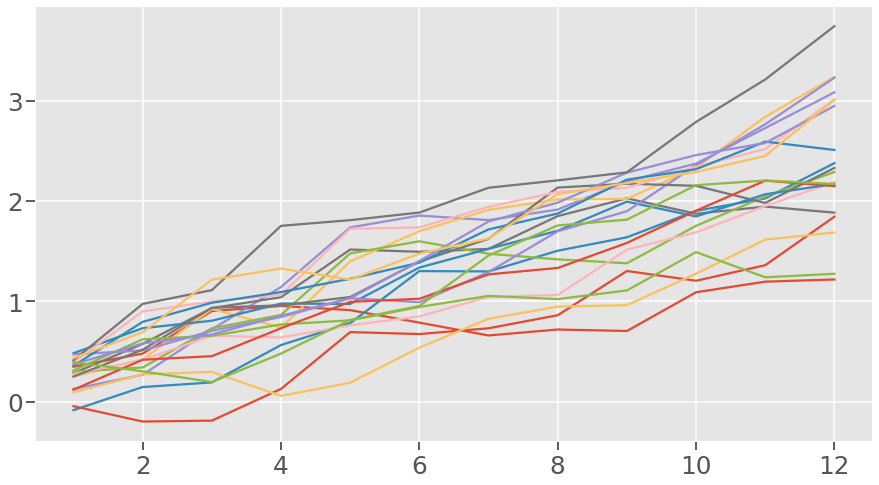

In [20]:
# apply the random walk model of sample size 20 for every month

n_months = 12; n_samples = 20

# first we make a 12 by 20 matrix with elt from normal model

mu_w = 0.2
sigma_w = 0.2




x = np.random.normal(loc=mu_w ,scale=sigma_w, size = (n_samples,n_months))
shape(x)

ws = x.swapaxes(1,0).cumsum(0)

plt.plot(np.arange(1,n_months+1), ws);
# use np.cumsum for cummulative summation and swapaxes method
# to swap the axes so that you match the first dimension 

In [21]:
# warming up for method generating

x, y = [1,2]
print(x,y)

x, y = (1,2)
print(x,y)

print("seems tuple or list can cast values to variables.")

print(logit(1/2)) # logarithm of odd
print("logit: log + odd. gives us a value of non probability")


print(expit(0)) # inverse logit: (1/(1+exp(-x))) gives us a prob

print(1+ np.array([[1,2,3],[4,5,6]]))

1 2
1 2
seems tuple or list can cast values to variables.
0.0
logit: log + odd. gives us a value of non probability
0.5
[[2 3 4]
 [5 6 7]]


In [22]:
# Define a method called 'randomwalk_prevalence'
# it takes w_mu, w_sigma, initial precalence and list of shape 
# returns dict of 'N', 'p' and 'x'
 
def random_walk_prevalence(mu, sigma, init_p=0.01, shape=None):
    
    '''Create overdose samples for data generating process, where
overdoses are a random walk in inverse logit space

 The pupulation N has uncertainty
 
 The prevalence of overdose in a given month is p from Beta
 
 Parameters
 __________
 mu : float
 drift of random walk in inv-logit space
 sigma: float
 standard deviation of random walk in inv-logit space
 init_p : float.... if default value is given, no explanation?
 shape: list
 shape of random walk in format (n_months, n_samples)
 
 Returns
 ----------
 numpy array
     Samples of random walk process with shape( n_months, n_samples)
#
'''
    n_samples,n_months  = shape

    es = np.random.normal(mu,sigma,size = (n_samples, n_months))

    init_p_transformed = logit(init_p)

    es_cumsum = es.cumsum(axis=1)

    ws = es_cumsum + init_p_transformed

    data = expit(ws) #expit gives us probability

    return data

# it gets us es, which is values from Normal distribution

# we change it as probability using inverse logit function

# we add initial prevalence which is basically a probability

# to the matrix after transformation by inverse logit ftn.

# then we transform the matrix into matrix of probability

# it generate N of size (1000, 1) from Normal (10000, 1000)
# also p of size (1000, 1) from Beta (1, 99)



In [23]:
n_months=12;n_samples=20
dt = random_walk_prevalence(0.2,0.2, shape=(n_samples,n_months))


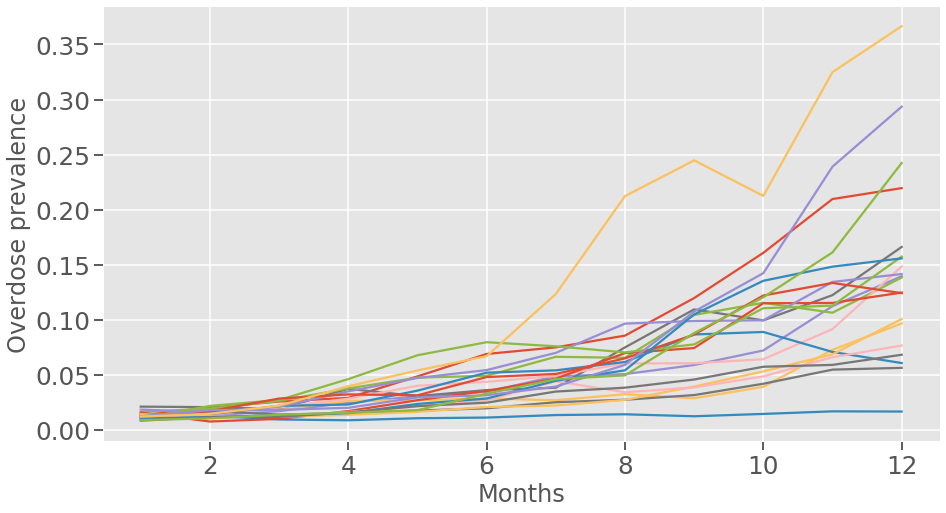

In [24]:
plt.xlabel('Months');plt.ylabel('Overdose prevalence')
plt.plot(np.arange(1,n_months+1),dt.swapaxes(0,1));

Basically this shows that when the first prevalence rate is 0.01 and the probability of overdose prevalence follows a certain normal distribution while the prevalence is random walk model, how the prevalence may increase over time. 

The method name was random_walk_prevalence. 

In [25]:
# Define a method called 'randomwalk_overdose_generation'
# it takes no argument, returns dict of 'N', 'p' and 'x'

# it generate N of size (1000, 1) from Normal (10000, 1000)
# p of size (1000, 12) from previous method.

def randomwalk_overdose_generation():
    '''Create overdose samples for data-generating process, where overdoeses
    are a random walk in inverse logit space.
    
        The pulunation N is from Normal(10000,1000)
        
        The pravalence of overdoses in a given month is p and is drawn from
        random walk of initial prevalence rate 0.01.
        Each month the rate p follows normal distributionmu_w 0.2 sigma_w 0.2.
        
        
    Parameters
    ---------
    None
    
    Returns 
    ---------
    dictionary
        Data generated for N,p and x.
    '''
    
    n_months, n_samples = 12, 1000
    N_mean, N_var = 10000, 1000
    
    N = np.random.normal(loc=N_mean, scale = N_var,size= (n_samples,1)).astype(int)
    mu_w, sigma_w = 0.2,0.2
    p = random_walk_prevalence(mu_w, sigma_w, shape=(n_samples,n_months))
    
    x = np.random.binomial(N,p, size = (n_samples,n_months))
    
    return {'N':N, 'p':p, 'x':x}


Remember that 'figure' is a kind of sketch book.
'subplot's are for the small plots inside of the sketch book (figure).

Text(0, 0.5, 'Counts')

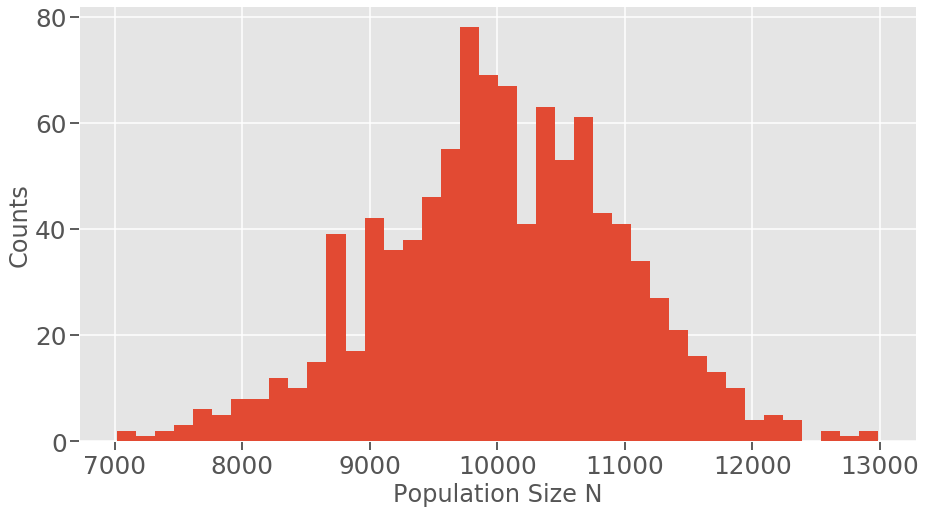

In [26]:
data = randomwalk_overdose_generation()
plt.figure;
plt.hist(data['N'],bins=40);
plt.xlabel('Population Size N');plt.ylabel('Counts')

In [27]:
size(data['p'])

12000

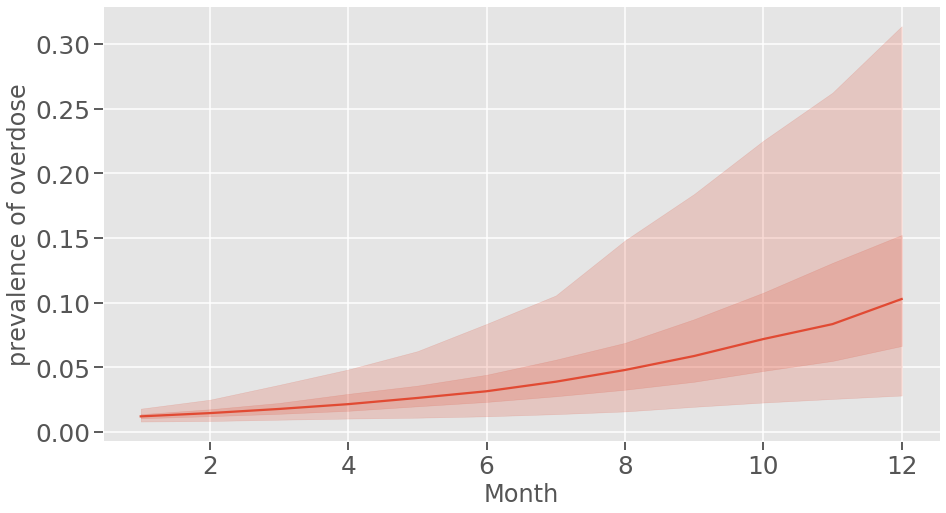

In [28]:
plot_data_timeseries(ys = data['p'],ylabel='prevalence of overdose')

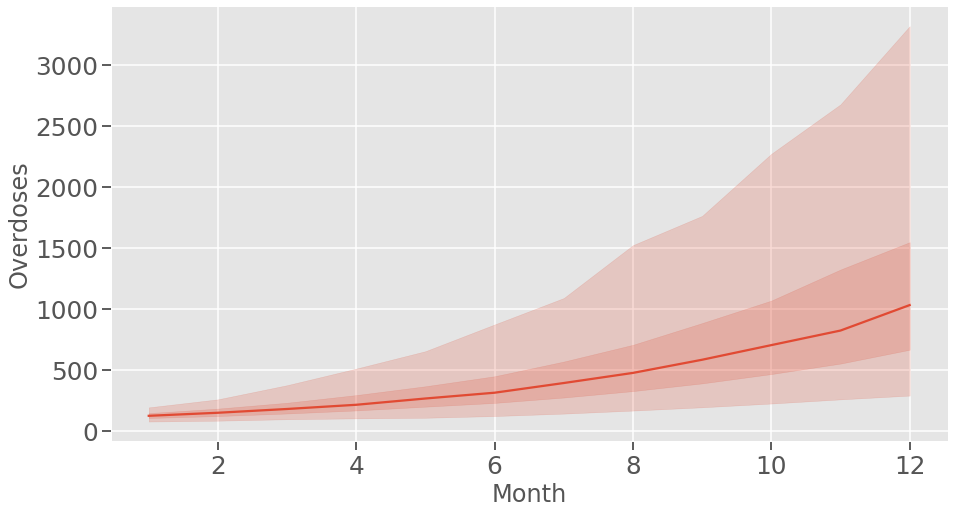

In [29]:
plot_data_timeseries(data['x'])

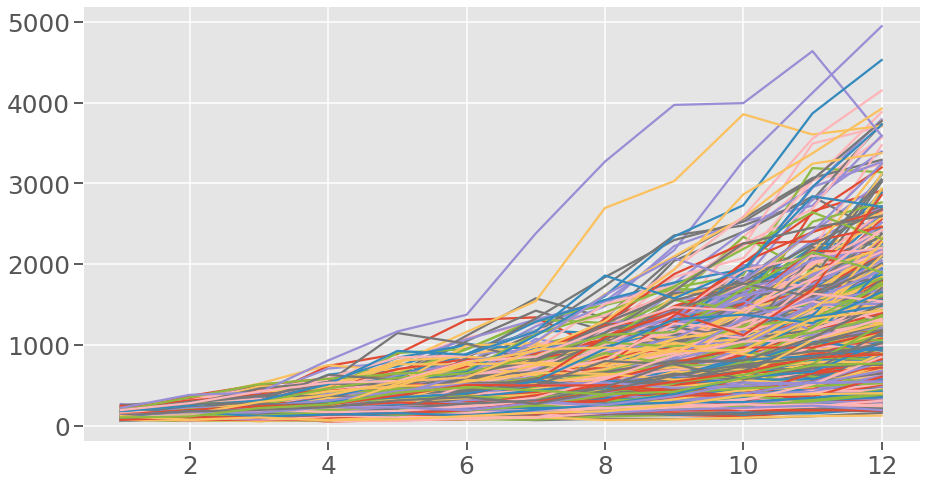

In [30]:
data = randomwalk_overdose_generation()
plt.plot(np.arange(1,n_months+1),data['x'].swapaxes(1,0));

We can see our plot method is better for visualization.

In [31]:
# Define a method called 'randomwalk_overdose_generation'
# it takes no argument, returns dict of 'N', 'p' and 'x'

# it generate N of size (1000, 1) from Normal (10000, 1000)
# p of size (1000, 12) from previous method.

def randomwalk_overdose_generation(N_mean= 10000, N_var= 1000, mu_w= 0.2, sigma_w=0.2, 
                                   n_months=12, n_samples=1000, init_p=0.01):
    '''Create overdose samples for data-generating process, where overdoeses
    are a random walk in inverse logit space.
    
        The pulunation N is from Normal(10000,1000)
        
        The pravalence of overdoses in a given month is p and is drawn from
        random walk of initial prevalence rate 0.01.
        Each month the rate p follows normal distributionmu_w 0.2 sigma_w 0.2.
        
        
    Parameters
    ---------
    None
    
    Returns 
    ---------
    dictionary
        Data generated for N,p and x.
    '''
    
    N = np.random.normal(loc=N_mean, scale = N_var,size= (n_samples,1)).astype(int)
    p = random_walk_prevalence(mu_w, sigma_w, init_p, shape=(n_samples,n_months))
    
    x = np.random.binomial(N,p, size = (n_samples,n_months))
    
    return {'N':N.flatten(), 'p':p, 'x':x}



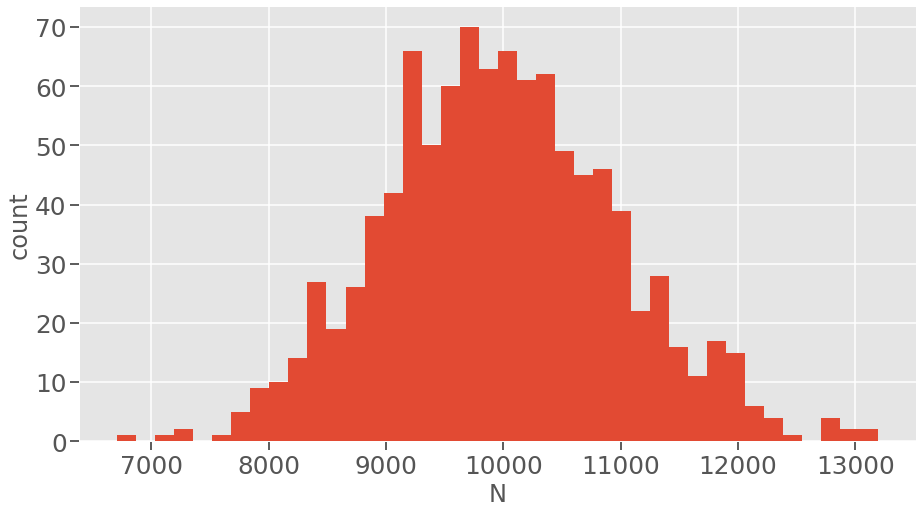

In [32]:
dt = randomwalk_overdose_generation(mu_w=0.0, sigma_w = 0.1)
plt.figure(); 
plt.hist(dt['N'], bins=40); plt.xlabel('N');plt.ylabel('count');



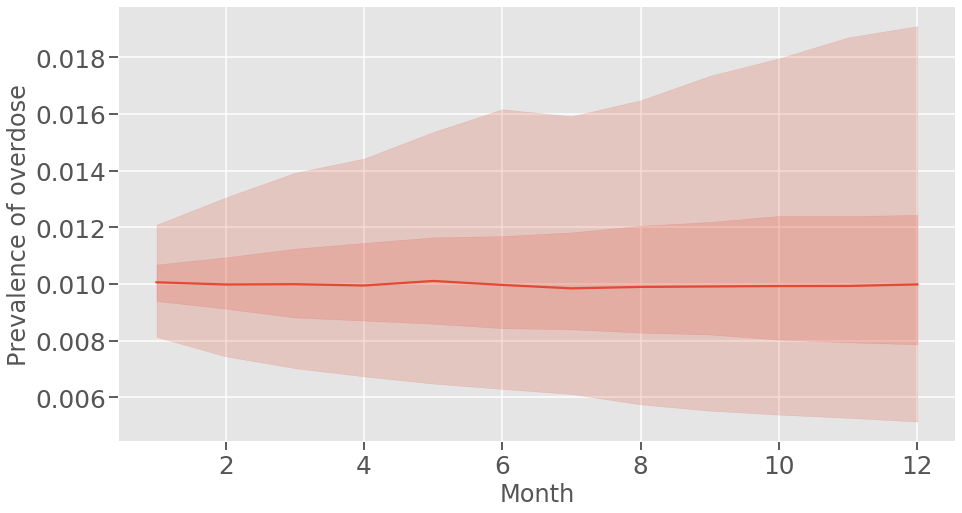

In [33]:
plot_data_timeseries(dt['p'],ylabel='Prevalence of overdose')


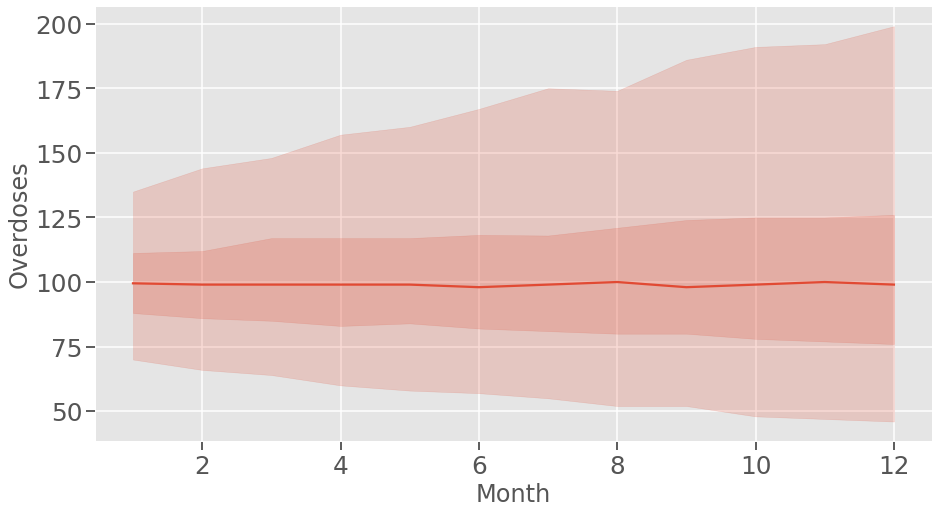

In [34]:
plot_data_timeseries(dt['x'])

# Question 0.
The goal of Bayesian inference is to find the probability of a set of parameters given some data. Normally we can write down the likelihood of observing some data $D$ given a set of parameters $\theta$. In the above example this would be a binomial probability, as that's what we used to generate the number of overdoses. Normally the likelihood is written as $P(D | \theta)$ (the probability of observing the data given the model parameters). The posterior is then written as $P( \theta | D)$ (the probability of observing the parameters given the data). The posterior can be written in terms of the likelihood using Bayes' rule,
$$ P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)} $$

**I don't think this is true**

# Question 1.
The prior is the probability of overdose prevalence $p$,
$$P(\theta) = P(p) \propto p^\alpha(1-p)^\beta.$$

In [35]:
D = np.array([40,50,51])


In [36]:
xs =np.linspace(0,0.02, num=1000)
# plt.plot(xs);

# hyper parameter
a,b = 1,99

pdf_prior = stats.beta(a,b).pdf(xs)

# D.size = 3 D.sum = 40+...+51
N= 10000
# posterior parameter of a, b
a_post = a + D.sum()
b_post = D.size*N + b - D.sum()
# post pdf of p

pdf_post = stats.beta(a_post, b_post).pdf(xs)

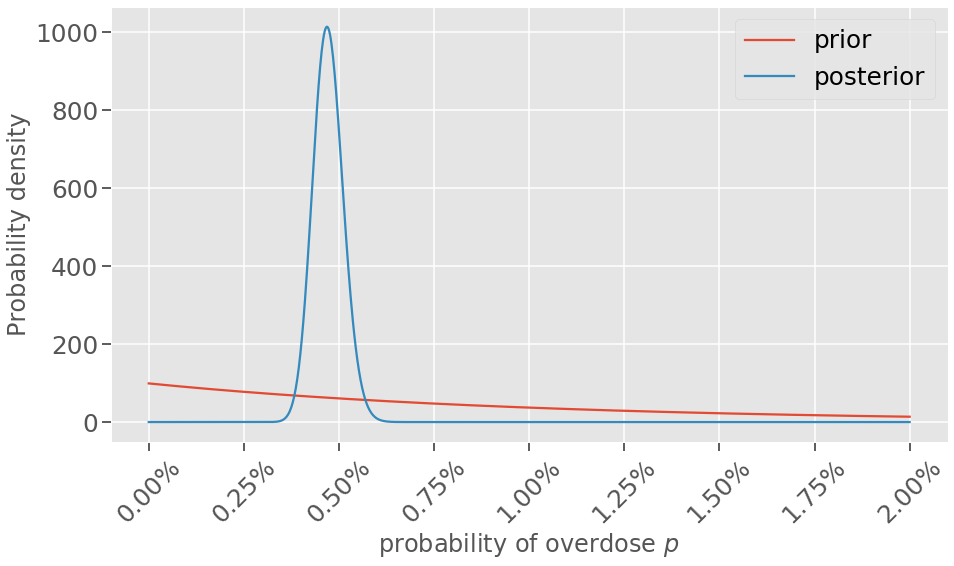

In [37]:
plt.figure();# figure is like a sketchbook

plt.plot(xs, pdf_prior, label='prior');
plt.plot(xs, pdf_post, label='posterior');
plt.xlabel('probability of overdose $p$');
plt.ylabel('Probability density');
plt.legend(); # the legend or colour

# sth to learn later
plt.gca().set_xticklabels(['{0:0.2%}'.format(x) for x in
                           plt.gca().get_xticks()], rotation=45);

How prior impacts posterior

In [38]:
def f(mu, log_sd):
    v = np.exp(log_sd)
    a = ((1 - mu) / v - 1 / mu) * mu ** 2
    b = a * (1 / mu - 1)
    pdf_prior = stats.beta(a,b).pdf(xs)
    
    a_post = a+ D.sum()
    b_post = b + D.size*N-D.sum()
    
    pdf_post = stats.beta(a_post, b_post).pdf(xs)
    
    plt.figure();
    plt.plot(xs, pdf_prior, label = 'prior');
    plt.plot(xs, pdf_post, label = 'post');
    plt.xlabel('probability of overdose $p$');
    plt.ylabel('Probability density');
    plt.legend();
    
    plt.gca().set_xticklabels(['{0:.2%}'.format(x) for x in plt.gca().get_xticks()],rotation=45);



In [39]:
interactive_plot = interactive(f, mu=(0.001, 0.02, 0.001),
                                      log_sd = (-20, -5, 0.1))
# nth happened
interactive_plot;

# mu = (min, max, step)
# logsd = (min, max, step)

In [40]:
# output = interactive_plot.children[-1]
# output # So children[-1] is deleting the slide

The children of the interactive are two integer-valued sliders and an output widget, produced by the widget abbreviations above.

In [41]:
#  interactive_plot.children


(FloatSlider(value=0.003,
description='mu', max=0.02, min=0.001, step=0.001),
 FloatSlider(value=-18.7,
description='log_sd', max=-5.0, min=-20.0),

Even getting into posterior is difficult in general, and there are to ways to do sampling from 'posterior' distribution. 
## 1. MCMC


$N \sim~ Normal(10000, 1000^2)$ : population   
$p \sim ~ Beta(1, 99)$: probability of overdose  
$x_t \sim Binomial(N, p)$: the number of overdose in a given month t 

In [42]:
# define number of months and number of samples
n_months =12
n_samples = 1000

# define prior for population size
N_mean, N_sigma = 10000, 1000

# define prior for probability of an overdose
p_alpha, p_beta = 1, 99

basic_model = pm.Model()
with basic_model:
    N = pm.Normal('N', mu = N_mean, sd = N_sigma)
    
    p = pm.Beta('p', alpha = p_alpha, beta = p_beta)
    
    x = pm.Binomial('x', n = N, p = p, shape=(n_months,))




We generate samples from the priors 

In [43]:
# with basic_model:
#     prior_trace = pm.sample(draws = 1000, step = pm.Slice()) # old version
#     # be careful: it's draws, not draw. 

In [44]:
with basic_model:
    prior_trace = pm.sample_prior_predictive(1000)

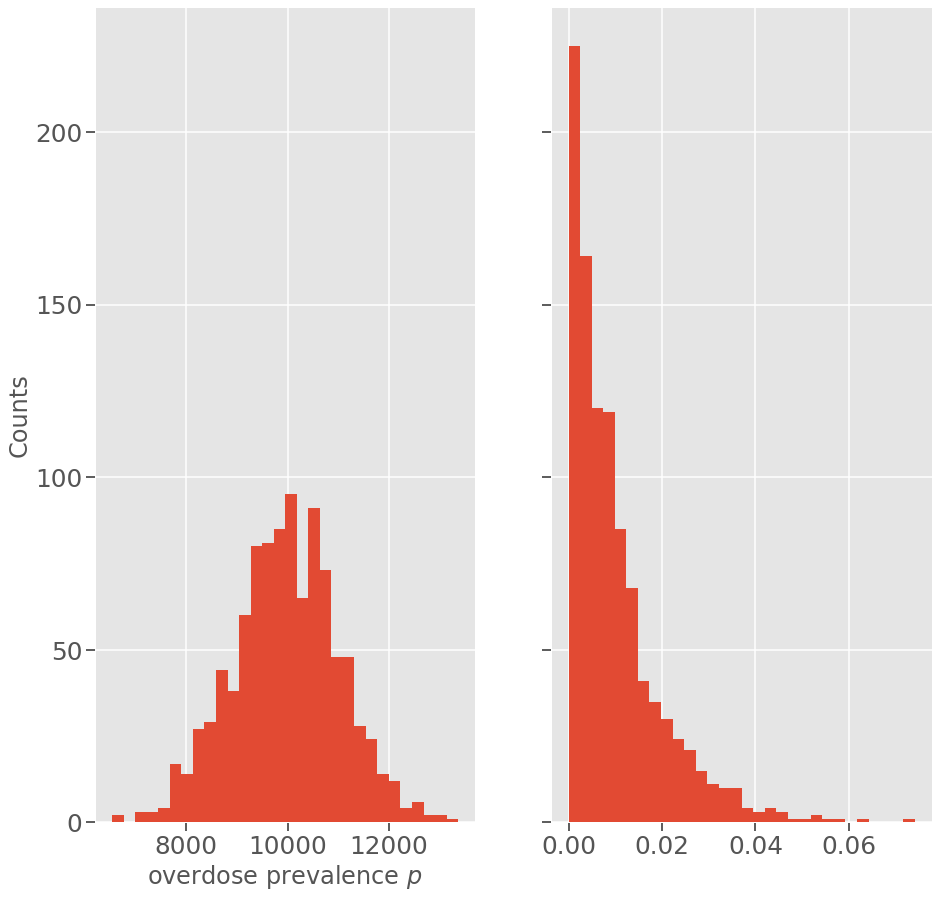

In [45]:
# Plotting the data 

fig, (ax1, ax2) = plt.subplots(1,2, sharey = True,figsize=(15,15)) # yes!!!!


ax1.hist(prior_trace['N'], bins = 30);
ax1.set_ylabel('Counts');
ax1.set_xlabel('Population size $N$');

ax2.hist(prior_trace['p'], bins= 30);
ax1.set_ylabel('Counts');
ax1.set_xlabel('overdose prevalence $p$');


In [46]:
# prior_trace.varnames
# well we do not have x though x is not totally deterministic.

why I don't have x ? they are random variable. is this because I don't have observed values?  

:That's because they are not prior of pure, but they are part of likelihood.  
We see that observed argument there in x, which means they are not prior.


## Generating a sample of the overdoses
We try not to sample discrete variables that aren't observed since they are extremely hard to generate. If you persist, use sample_ppc method.

In [47]:
# with basic_model:
#     prior_ppc = pm.sample_ppc(prior_trace)
    # old version: deprecated

In [48]:
# np.expand_dims(data, axis)
# prior_ppc['x'].shape

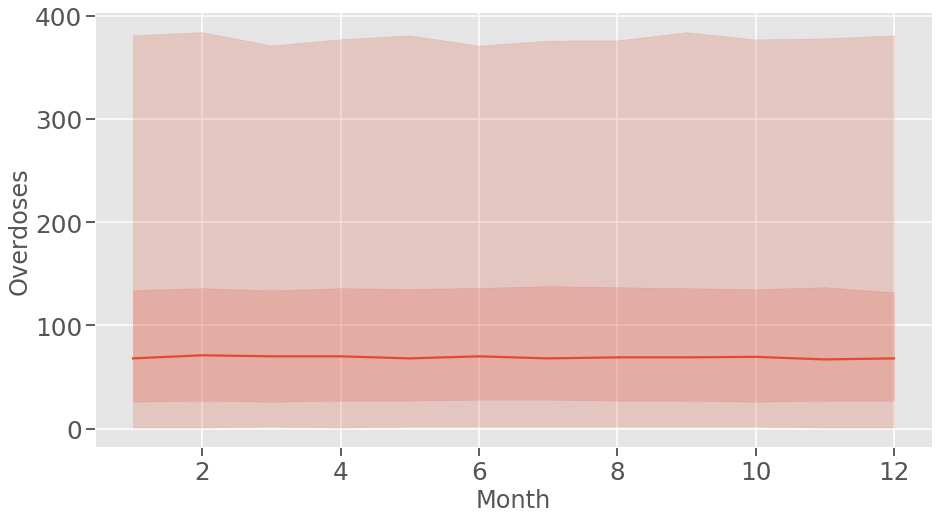

In [49]:

plot_data_timeseries(prior_trace['x'])

**There is a problem about the shape of x. shape=(n_months, n_shapes) not working and the original is not working as well.**  

We keep going.

## Fitting to data

In [50]:
model_data = pm.Model()
D = np.array([88, 115,  93, 145, 154, 134, 144, 141, 170, 136, 131, 147])
with model_data:
    N=pm.Normal('N', N_mean, N_sigma)
    p = pm.Beta('p', p_alpha, p_beta)
    x = pm.Binomial('x', n=N, p=p, shape = n_months, observed = D)

In [51]:
with model_data:
    posterior_trace = pm.sample(1000, step=pm.Slice())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [p]
>Slice: [N]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1547.89draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [52]:
with model_data:
    posterior_ppc = pm.sample_ppc(posterior_trace)

/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 2000/2000 [00:01<00:00, 1349.50it/s]


In [53]:
posterior_ppc['x'].shape

(2000, 12)

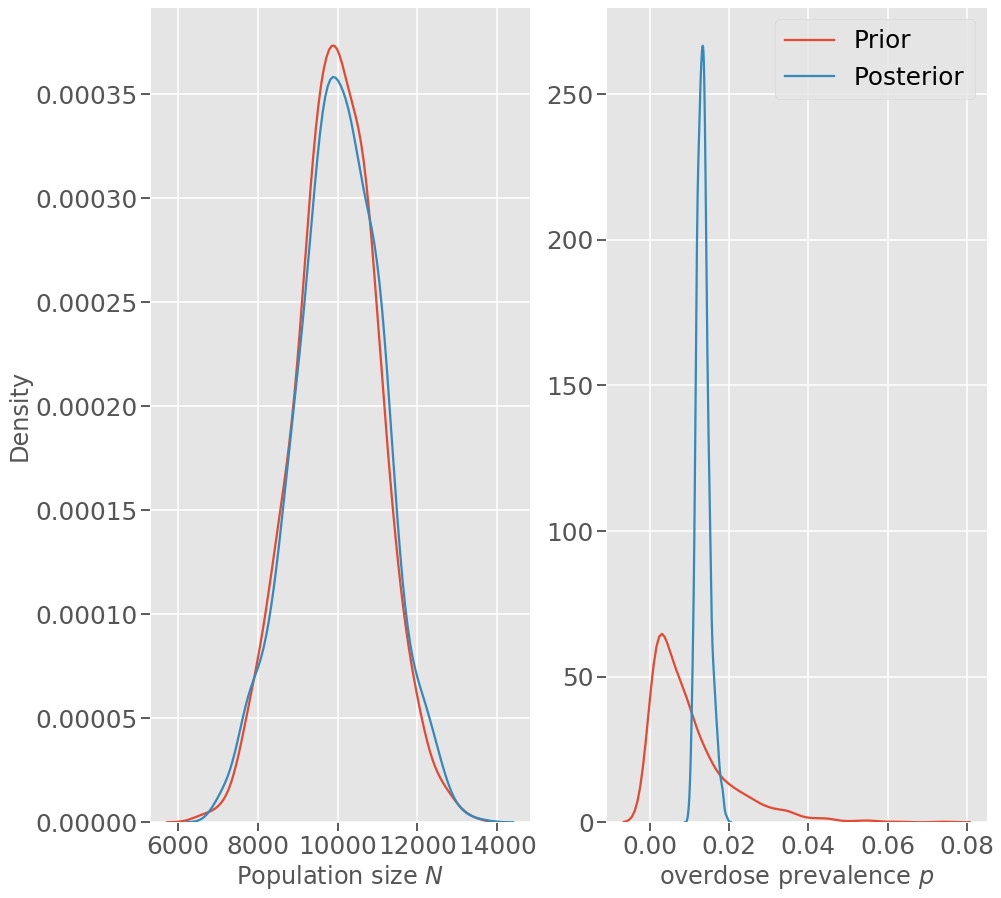

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = False, figsize=(15,15))
sns.kdeplot(prior_trace['N'], ax= ax1 );
sns.kdeplot(posterior_trace['N'], ax= ax1);
ax1.set_xlabel('Population size $N$');
ax1.set_ylabel('Density');

sns.kdeplot(prior_trace['p'], ax= ax2, label = 'Prior');
sns.kdeplot(posterior_trace['p'], ax= ax2, label = 'Posterior');
ax2.set_xlabel('overdose prevalence $p$');
ax2.legend()


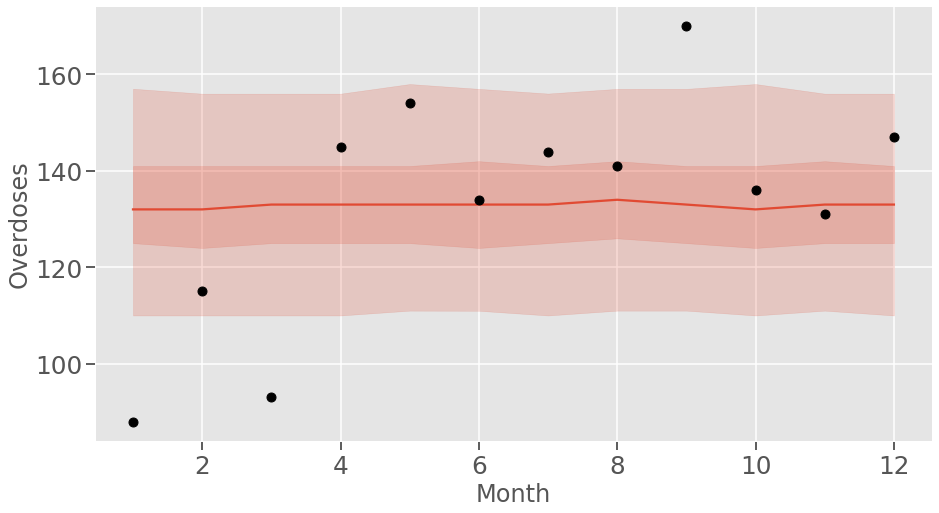

In [55]:
plt.figure(figsize=(15,8))
plot_data_timeseries(posterior_ppc['x']);
plt.plot(np.arange(1,n_months+1), D, 'ko')

## Variational Bayes  

I will skip this part for now.


In [56]:
# with model_data:
#     v_params = pm.variational.approximations(n=10000)
#     variational_trace = pm.variational.adam(v_params, draws= 1000)
    

## Adding in time variation  
Gaussian Random Walk$$w_t \sim w_{t-1} + N(\mu_w,\sigma_w^2)$$ 

In [66]:
def create_timeseries_model(N_mean = 10000, N_sd = 1000, p0=0.01, mu_w = 0.0, sd_w= 0.1,
                           overdoses= None): # default values when not specified
    '''
    Create pymc3 time-series overdose model
    
    Parameters
    ----------
    N_mean : float
        mean of population size
    N_sd : float
        standard deviation of population size
    p0 : float
        initial prevalence of overdoses
    mu_w : float
        drift for overdose random walk
    sd_w : float
        variance for overdose random walk
    overdoses : numpy array
        overdose data. empty array is sampling from prior
    
    Returns
    -------
    
    Pymc3 model
    
    '''
    model = pm.Model()
    
    with model:
        N=pm.Normal('N', N_mean, N_sd)
        w = GaussianRandomWalk('w', mu = mu_w, sigma=sd_w, shape = (n_months,),
                               init = pm.Normal.dist(mu=logit(p0), sd= 0.1))
    
        p = pm.Deterministic('p', pm.invlogit(w))
        
        # generate data (we assume we haven't observed any data so far to draw from the prior)
        if overdoses is not None:
            x = pm.Binomial('x', n=N.astype('int64'), p=p, shape=(n_months,), observed = overdoses)
            
    return model
        
        

In [58]:
model_time = create_timeseries_model()

In [60]:
with model_time:
    prior_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, N]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 387.21draws/s]
The number of effective samples is smaller than 25% for some parameters.


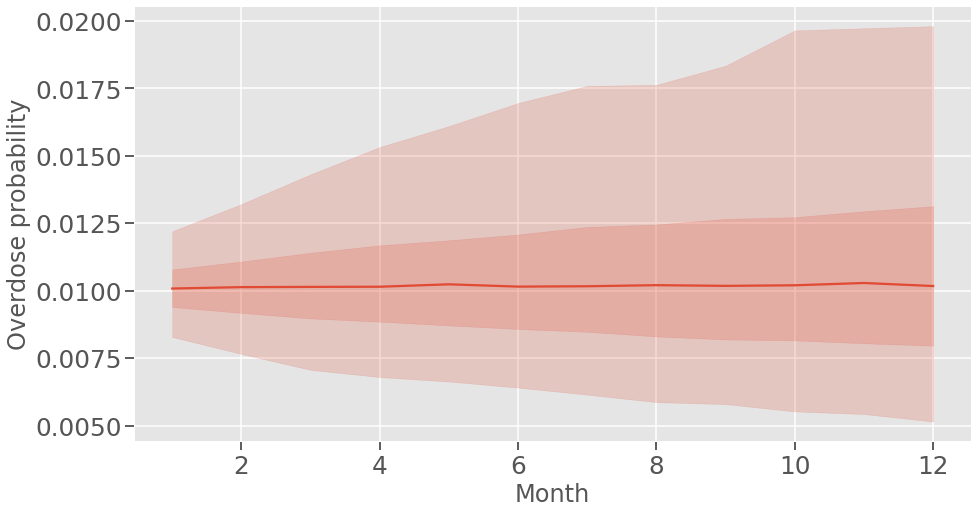

In [61]:
plot_data_timeseries(prior_trace['p'], ylabel="Overdose probability")

In [65]:
# with model_time:
#     prior_trace2 = pm.sample_prior_predictive(1000)
    

ValueError: Cannot resolve inputs for ['w', 'p']

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-65-b07e9ca71ca7> in <module>
      1 with model_time:
----> 2     prior_trace2 = pm.sample_prior_predictive(1000)
      3 plot_data_timeseries(prior_trace2['p'], ylabel="Overdose probability")

~/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py in sample_prior_predictive(samples, model, vars, var_names, random_seed)
   1320     names = get_default_varnames(model.named_vars, include_transformed=False)
   1321     # draw_values fails with auto-transformed variables. transform them later!
-> 1322     values = draw_values([model[name] for name in names], size=samples)
   1323 
   1324     data = {k: v for k, v in zip(names, values)}

~/anaconda3/lib/python3.7/site-packages/pymc3/distributions/distribution.py in draw_values(params, point, size)
    411         while to_eval or missing_inputs:
    412             if to_eval == missing_inputs:
--> 413                 raise ValueError('Cannot resolve inputs for {}'.format([str(params[j]) for j in to_eval]))
    414             to_eval = set(missing_inputs)
    415             missing_inputs = set()

ValueError: Cannot resolve inputs for ['w', 'p']  



**why getting this error? what is prior_predictive_distribution?**

In [ ]:
# plot_data_timeseries(prior_trace2['p'], ylabel="Overdose probability")

Signature: pm.math.invlogit(x, eps=2.220446049250313e-16)
Docstring: The inverse of the logit function, 1 / (1 + exp(-x)).
File:      ~/anaconda3/lib/python3.7/site-packages/pymc3/math.py
Type:      function   


Signature: pm.invlogit(x, eps=2.220446049250313e-16)
Docstring: The inverse of the logit function, 1 / (1 + exp(-x)).
File:      ~/anaconda3/lib/python3.7/site-packages/pymc3/math.py
Type:      function

* pm.invlogit = pm.math.invlogit  


**seems sometimes I can skip the intermediate part of the package or module names**

In [67]:
model_time_data = create_timeseries_model(overdoses=D)
with model_time_data:
    posterior_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, N]
Sampling 2 chains: 100%|██████████| 3000/3000 [03:48<00:00, 13.13draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


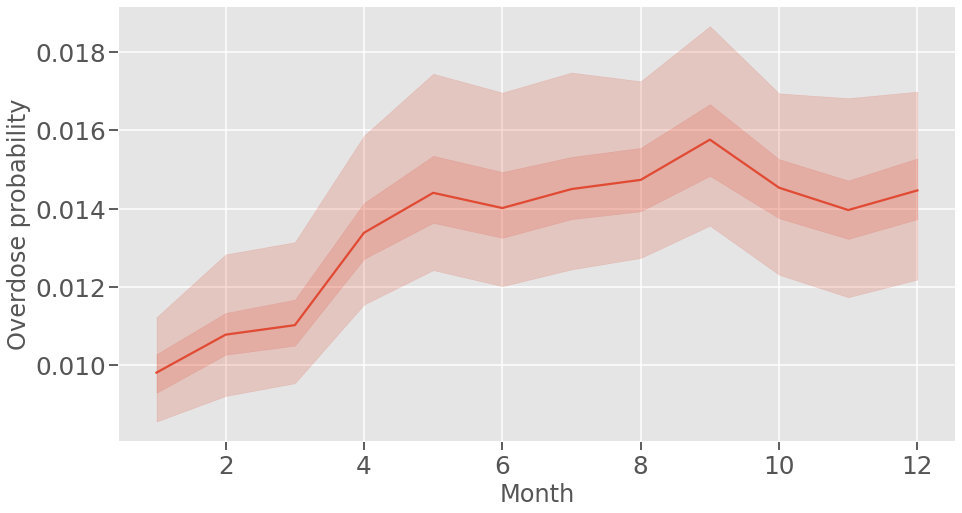

In [68]:
plot_data_timeseries(posterior_trace['p'], ylabel="Overdose probability")

In [84]:
with model_time_data:
    posterior_predictive_trace = pm.sample_posterior_predictive(posterior_trace, samples=1000)

100%|██████████| 1000/1000 [00:04<00:00, 220.03it/s]


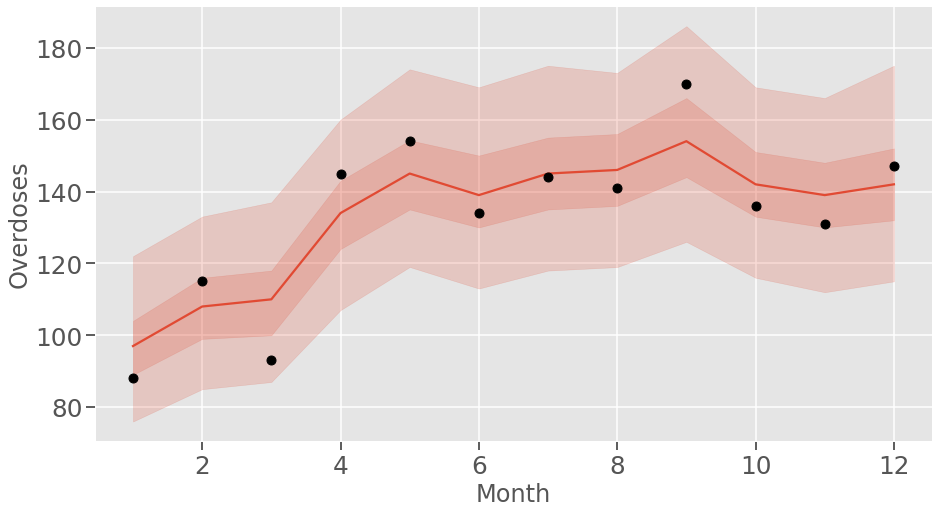

In [90]:
plot_data_timeseries(posterior_predictive_trace['x'], ylabel="Overdoses")
plt.plot(np.arange(1,n_months+1), D, 'ko');

## Adding in Death Data

In [92]:
data = pd.read_csv('./data/data_sample.csv')

In [93]:
data

,month,overdoses,fentanyl deaths,deaths,kits distributed,kits used
0,1,221,2,23,34.0,2
1,2,254,10,31,35.0,0
2,3,266,9,25,110.0,3
3,4,408,27,42,140.0,10
4,5,661,52,68,360.0,19
5,6,965,78,87,752.0,78
6,7,1377,128,132,793.0,101
7,8,1512,146,151,823.0,110
8,9,1640,164,170,903.0,159
9,10,1630,150,153,908.0,137


In [105]:
data.columns
observables = [c for c in data.columns if c != 'month']

In [106]:
type(observables)

list

In [107]:
observables

['overdoses', 'fentanyl deaths', 'deaths', 'kits distributed', 'kits used']

In [104]:
type(data.columns)

pandas.core.indexes.base.Index

In [111]:
(data['month'].values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [113]:
for i,j in enumerate(observables):
    print(i,j)

0 overdoses
1 fentanyl deaths
2 deaths
3 kits distributed
4 kits used


In [ ]:
plt.subplot()

In [115]:
n_months

12

In [132]:
# plot data 
def plot_dataframe(data):
    '''plot example data from data frame
    
    '''
    plt.figure(figsize=(16,16));
    names = data.columns
    observables = [c for c in names if c!= 'month']
    for i,j in enumerate(observables):
        plt.subplot(3,2,i+1);
        plt.plot(np.arange(1, n_months+1), data[j].values);
        plt.ylabel(j);
        if (i==4) or (i==5):
            plt.xlabel('month');

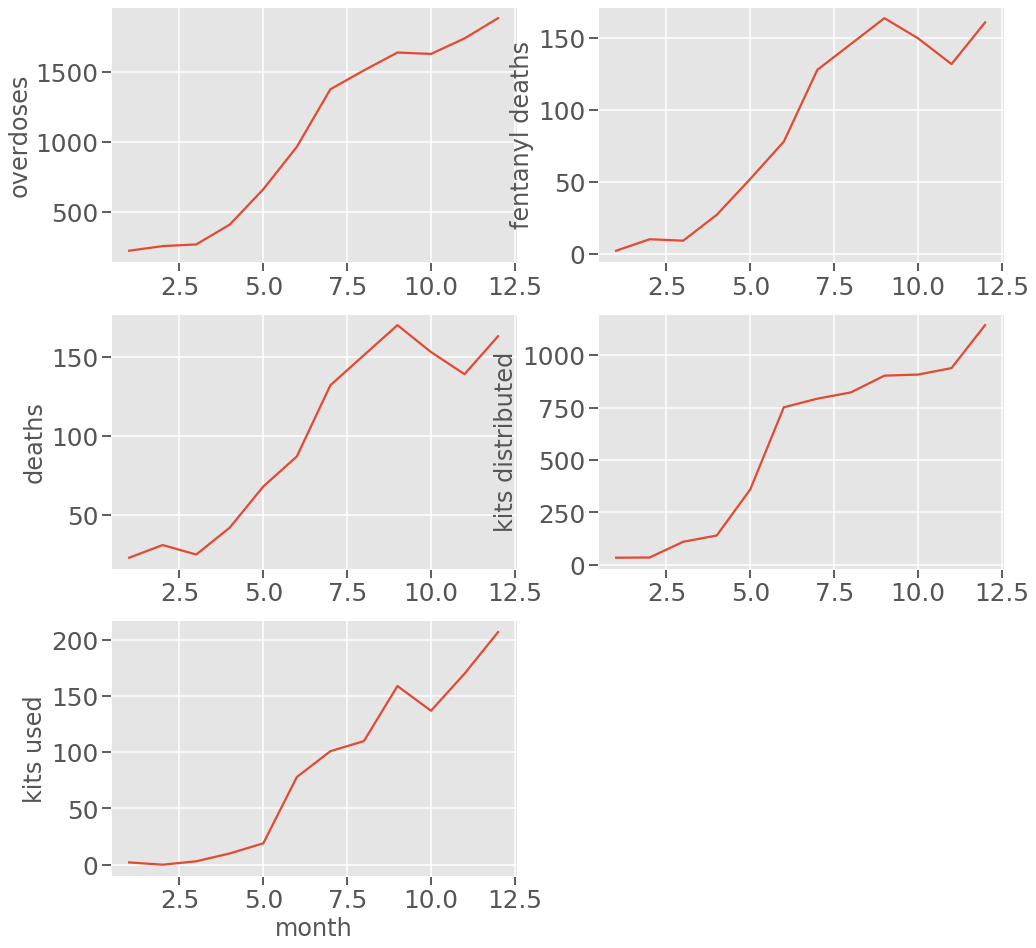

In [133]:
plot_dataframe(data)

## Adding the model to death data   

**Let's roughly remember for now that Posterior Predictive Check is simulating a data from posterior predictive distribution and then compare them to the given data to see if there is any systemical discrepency.**  


**Then I guess sample_posterior_predictive vs sample is the way to do that using MCMC, but not by using varitional Bayes ?**

In [143]:
def create_timeseries_death_model(N_mean=10000, N_sd=1000, p0= 0.01, mu_w=0, sd_w=0.1,
                                  mu_pd=0.1, sigma_pd=0.05, overdoses=None, 
                                  deaths=None):
    """
    Create pymc3 time-series overdose model
    
    Parameters
    ----------
    N_mean : float
        mean of population size
    N_sd : float
        standard deviation of population size
    p0 : float
        initial prevalence of overdoses
    mu_w : float
        drift for overdose random walk
    sd_w : float
        variance for overdose random walk
    mu_pd : float
        mean probability of death following an overdose
    sigma_pd : float
        sd probability of death following an overdose
    overdoses : numpy array
        overdose data
    deaths : numpy array
        death data
    
    Returns
    -------
    
    Pymc3 model
    
    """
    with pm.Model() as model:
        
        N = pm.Normal('N', mu = N_mean, sigma = N_sd)
        w = pm.GaussianRandomWalk('w',mu = mu_w, sigma=sd_w, shape=(n_months,),
                                  init=pm.Normal.dist(mu=pm.logit(p0), sd= 0.1))
        p = pm.Deterministic('p',pm.invlogit(w))
        pd = pm.Beta('p_d',mu= mu_pd, sigma = sigma_pd)
        
        if overdoses is not None:
            x = pm.Poisson('overdoeses',mu = N*p, shape = (n_months,), observed= overdoses)
        if deaths is not None:
            d = pm.Poisson('deaths', mu = N*p*pd, shape = (n_months,), observed=deaths)
        
    
    return model

In [138]:
type(data['overdoses'])

pandas.core.series.Series

In [139]:
type(data['overdoses'].values)

numpy.ndarray

In [146]:
def generate_ppc_from_model(model):
    '''
    Generate trace and ppc from a pymc3 model using MCMC.
    
    Parameters
    ----------
    
    model : pymc3 model
    
    Return
    ------ 
    
    dict
        dictionary containing the trace and ppc
    '''
    print("Generating samples from posterior distributions using MCMC")
    with model:
        trace = pm.sample(1000)
        
    print("Generating posterior predictive checks...")
    with model:
        ppc = pm.sample_posterior_predictive(trace)
    
    return {'trace':trace, 'ppc':ppc}

In [148]:
model= create_timeseries_death_model(overdoses = data['overdoses'].values,
                                               deaths=data['deaths'].values)

In [153]:
# with model:
#     trace = pm.sample(2000)

In [154]:
# fit= generate_ppc_from_model(model)

In [157]:
with model:
    trace = pm.sample(1000,init='advi')
    

# with model:
#     trace = pm.variational.sample_vp(v_params, draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 205.97:   8%|▊         | 15925/200000 [00:11<02:12, 1385.22it/s] 
Convergence achieved at 16000
Interrupted at 15,999 [7%]: Average Loss = 7,324.9
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_d, w, N]
Sampling 2 chains:   0%|          | 0/3000 [00:02<?, ?draws/s]


ValueError: Not enough samples to build a trace.